In [ ]:
# NOTE utilised numbers are below, when I removed repeats from gal_ids and removed indices which were not in the no jets run simulation (7 and 19).

In [ ]:
import h5py

def count_galaxies_in_h5(file_path):
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as hf:
        if 'gal_ids' in hf:
            gal_ids = hf['gal_ids'][:]
            print(gal_ids)
            total_galaxies = len(gal_ids)
            print(f"Total number of galaxies saved: {total_galaxies}")
        else:
            print("Dataset 'gal_ids' not found in the file.")

file_path = '/home/pedroleo/pedroshp/samples/m50n512_s50_078_galaxy_sample.h5'
count_galaxies_in_h5(file_path)


In [ ]:
import h5py
import numpy as np

def quench_thresh(z):  # in units of yr^-1 
    return -0.8 + 0.3 * z - 9.

def ssfr_type_check(ssfr_thresh, ssfr):
    sf_mask = ssfr >= ssfr_thresh
    gv_mask = (ssfr < ssfr_thresh) & (ssfr > ssfr_thresh - 1)
    q_mask = ssfr < (ssfr_thresh - 1)
    return sf_mask, gv_mask, q_mask

def count_galaxy_types(file_path, z):
    with h5py.File(file_path, 'r') as hf:
        if 'ssfr' in hf and 'gal_ids' in hf:
            ssfr = hf['ssfr'][:] 
            gal_ids = hf['gal_ids'][:]
            total_galaxies = len(gal_ids)
            print(f"Total number of galaxies in file: {total_galaxies}")

            # Calculate thresholds based on the redshift
            ssfr_thresh = quench_thresh(z)

            # Use the ssfr to check galaxy types
            sf_mask, gv_mask, q_mask = ssfr_type_check(ssfr_thresh, ssfr)
            sf_count = np.sum(sf_mask)
            gv_count = np.sum(gv_mask)
            q_count = np.sum(q_mask)

            print(f"Star-forming galaxies: {sf_count}")
            print(f"Green valley galaxies: {gv_count}")
            print(f"Quenched galaxies: {q_count}")
        else:
            print("Required datasets 'ssfr' or 'gal_ids' not found in the file.")


redshift = 2.024621 # from http://simba.roe.ac.uk/outputs.txt
file_path = '/home/pedroleo/pedroshp/samples/m50n512_s50_078_galaxy_sample.h5'
count_galaxy_types(file_path, redshift)


In [ ]:
"""plotting our galaxy sample for different SFR categories"""

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import numpy as np
import sys
import caesar

def ssfr_b_redshift(z):
    return 1.9*np.log10(1+z) - 7.7

def belfiore_line(mstar, a=0.73, b=-7.7):
    return mstar*a + b

def sfms_line(mstar, a=1., b=-10.8):
    return mstar*a + b

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({},{:.2f},{:.2f})'.format(cmap.name, minval, maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def convert_to_log(y, yerr):
    yerr /= (y * np.log(10.))
    y = np.log10(y)
    return y, yerr

def runningmedian(x, y, xlolim=-1.e20, ylolim=-1.e20, bins=10, stat='median'):
    xp = x[(x > xlolim) & (y > ylolim)]
    yp = y[(x > xlolim) & (y > ylolim)]
    hist, bin_edges = np.histogram(xp, bins)
    bin_cent = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ymedian = np.zeros(bins)
    ysigma = np.zeros(bins)
    for i in range(bins):
        mask = (xp > bin_edges[i]) & (xp < bin_edges[i+1])
        ymedian[i] = np.median(10**yp[mask])
        ysigma[i] = np.std(10**yp[mask])
    ymedian, ysigma = convert_to_log(ymedian, ysigma)
    return bin_cent, ymedian, ysigma

# No LaTeX
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', size=15)

cmap = plt.get_cmap('plasma')
cmap = truncate_colormap(cmap, 0.1, 0.9)
greys = plt.get_cmap('Greys')
greys = truncate_colormap(greys, 0.0, 0.5)

def quench_thresh(z):
    return -0.8 + 0.3*z -9.


if __name__ == '__main__':
    model = "m50n512"
    wind = "s50"
    snap = "078"
    data_dir = f'/home/rad/data/{model}/{wind}/'
    sim = caesar.load(f'{data_dir}Groups/{model}_{snap}.hdf5') 
    redshift = sim.simulation.redshift
    quench = quench_thresh(redshift)

    sample_dir = '/home/pedroleo/pedroshp/samples/'
    sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'

    with h5py.File(sample_file, 'r') as sf:
        gal_sm = sf['mass'][:]
        gal_sfr = sf['sfr'][:]
        gal_ssfr = sf['ssfr'][:] + 9.

    sm_line = np.arange(9.5, 12.5, 0.5)
    sf_line = sfms_line(sm_line, b=quench)
    q_line = sfms_line(sm_line, b=quench - 1.)

    #plt.scatter(gal_sm, np.log10(gal_sfr + 1e-3), c="black", cmap=cmap, s=10, marker='o', vmin=5, vmax=7, label='Galaxy sample')
    plt.scatter(gal_sm, np.log10(gal_sfr + 1e-3), c="black", s=10, marker='o', label='Galaxy sample')
    plt.plot(sm_line, sf_line, '--', c='dimgray', label='Star Forming Main Sequence')
    plt.plot(sm_line, q_line, '--', c='dimgray', label='Quenching Threshold')
    plt.xlabel(r'$\log (M_{\star} / M_{\odot})$')
    plt.ylabel(r'$\log ({\rm sSFR} / {\rm yr}^{-1})$')

    plt.rcParams["figure.figsize"] = (12,8)
    plt.legend()
    plt.show()


In [ ]:
"""Checking how many galaxies in each mass bin I define, in the entire simulation run"""

import caesar
import yt
import numpy as np
import sys

def main(model, wind, snap):
    data_dir = f'/home/rad/data/{model}/{wind}/'
    sim = caesar.load(f'{data_dir}Groups/{model}_{snap}.hdf5')
    
    # Extract the stellar masses and convert them to solar masses
    stellar_masses = np.array([galaxy.masses['stellar'].in_units('Msun') for galaxy in sim.galaxies])
    
    # Define the mass bins
    min_mass = 10**10  # Minimum stellar mass in solar masses
    max_mass = 10**12  # Maximum stellar mass in solar masses
    bins = 6  # Number of bins
    
    # Use logarithmic spacing for the bins
    mass_bins = np.logspace(np.log10(min_mass), np.log10(max_mass), bins + 1)
    
    # Use histogram to count galaxies in each bin
    counts, edges = np.histogram(stellar_masses, bins=mass_bins)
    
    for i in range(len(counts)):
        print(f"Mass range {edges[i]:.2e} Msun to {edges[i+1]:.2e} Msun: {counts[i]} galaxies")

if __name__ == "__main__":
    model = "m50n512"
    wind = "s50"
    snap = "078"
    main(model, wind, snap)


In [ ]:
"""getting gal_ids for each of the SFR categories"""

import h5py
import numpy as np

def quench_thresh(z):  # in units of yr^-1 
    return -0.8 + 0.3 * z - 9.

def ssfr_type_check(ssfr_thresh, ssfr):
    sf_mask = ssfr >= ssfr_thresh
    gv_mask = (ssfr < ssfr_thresh) & (ssfr > ssfr_thresh - 1)
    q_mask = ssfr <= (ssfr_thresh - 1)
    return sf_mask, gv_mask, q_mask

def count_galaxy_types(file_path, z):
    galaxy_types = {'Star-forming': [], 'Green valley': [], 'Quenched': []}

    with h5py.File(file_path, 'r') as hf:
        if 'ssfr' in hf and 'gal_ids' in hf:
            ssfr = hf['ssfr'][:] 
            gal_ids = hf['gal_ids'][:]
            total_galaxies = len(gal_ids)
            print(f"Total number of galaxies in file: {total_galaxies}")

            # Calculate thresholds based on the redshift
            ssfr_thresh = quench_thresh(z)

            # Use the ssfr to check galaxy types
            sf_mask, gv_mask, q_mask = ssfr_type_check(ssfr_thresh, ssfr)

            # Save galaxy IDs based on the mask
            galaxy_types['Star-forming'] = gal_ids[sf_mask]
            galaxy_types['Green valley'] = gal_ids[gv_mask]
            galaxy_types['Quenched'] = gal_ids[q_mask]

            print(f"Star-forming galaxies: {np.sum(sf_mask)}, IDs: {gal_ids[sf_mask]}")
            print(f"Green valley galaxies: {np.sum(gv_mask)}, IDs: {gal_ids[gv_mask]}")
            print(f"Quenched galaxies: {np.sum(q_mask)}, IDs: {gal_ids[q_mask]}")
        else:
            print("Required datasets 'ssfr' or 'gal_ids' not found in the file.")

    return galaxy_types


redshift = 2.024621
file_path = '/home/pedroleo/pedroshp/samples/m50n512_s50_078_galaxy_sample.h5'
galaxy_ids_by_type = count_galaxy_types(file_path, redshift)


In [ ]:
star_forming_ids = [318, 322, 257, 319, 332, 295, 265, 261, 303, 340, 148, 198, 186, 183, 148, 189, 96, 125, 128, 118, 119, 84, 57, 74, 74, 75, 28, 50, 26, 38, 26, 49, 10, 7, 15, 13]
green_valley_ids = [185, 184, 177, 90, 137, 130, 90, 80, 83, 71, 83, 39, 39, 8, 12, 19, 8, 18]
quenched_ids = [217, 246, 253, 154, 210, 211, 210, 124, 97, 133, 93, 126, 91, 62, 66, 56, 36, 37, 47, 41, 45, 9]


In [ ]:
# With new numbers! (Removing repeats and galaxies not present in nojet simulation)

for i in range(10):
    print("PAY ATTENTION, NOW WITH NEW NUMBERS! ---------------------------------")

In [ ]:
import h5py

def count_galaxies_in_h5(file_path):
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as hf:
        if 'gal_ids' in hf:
            gal_ids = hf['gal_ids'][:]
            unique_gal_ids = list(set(gal_ids))  # Remove duplicates
            unique_gal_ids.sort()  # Optional: sort the IDs
            total_galaxies = len(unique_gal_ids)
            print("Unique galaxy IDs:", ", ".join(map(str, unique_gal_ids)))
            print(f"Total number of unique galaxies: {total_galaxies}")
        else:
            print("Dataset 'gal_ids' not found in the file.")

file_path = '/home/pedroleo/pedroshp/samples/m50n512_s50_078_galaxy_sample.h5'
count_galaxies_in_h5(file_path)

In [ ]:
# Without repeats (not complete yet):
#gal_ids = [7, 8, 9, 10, 12, 13, 15, 18, 19, 26, 28, 36, 37, 38, 39, 41, 45, 47, 49, 50, 56, 57, 62, 66, 71, 74, 75, 80, 83, 84, 90, 91, 93, 96, 97, 118, 119, 124, 125, 126, 128, 130, 133, 137, 148, 154, 177, 183, 184, 185, 186, 189, 198, 210, 211, 217, 246, 253, 257, 261, 265, 295, 303, 318, 319, 322, 332, 340]

# Withouts repeats AND without missing galaxies in nojet counterpart. (ie. ID's 19 and 7)

gal_ids = [8, 9, 10, 12, 13, 15, 18, 26, 28, 36, 37, 38, 39, 41, 45, 47, 49, 50, 56, 57, 62, 66, 71, 74, 75, 80, 83, 84, 90, 91, 93, 96, 97, 118, 119, 124, 125, 126, 128, 130, 133, 137, 148, 154, 177, 183, 184, 185, 186, 189, 198, 210, 211, 217, 246, 253, 257, 261, 265, 295, 303, 318, 319, 322, 332, 340]

print("expected number: 66")
print("gal_ids list length:" , len(gal_ids))

In [ ]:
import h5py
import numpy as np

def quench_thresh(z):  # in units of yr^-1 
    return -0.8 + 0.3 * z - 9.

def ssfr_type_check(ssfr_thresh, ssfr):
    sf_mask = ssfr >= ssfr_thresh
    gv_mask = (ssfr < ssfr_thresh) & (ssfr > ssfr_thresh - 1)
    q_mask = ssfr <= (ssfr_thresh - 1)
    return sf_mask, gv_mask, q_mask

def count_galaxy_types(file_path, z):
    with h5py.File(file_path, 'r') as hf:
        if 'ssfr' in hf and 'gal_ids' in hf:
            ssfr = hf['ssfr'][:]
            gal_ids = hf['gal_ids'][:]

            # Create a mask to ignore specific gal_ids and remove duplicates
            ignore_ids = {7, 19}
            unique_gal_ids, indices = np.unique(gal_ids, return_index=True)
            valid_indices = [idx for idx, gal_id in zip(indices, unique_gal_ids) if gal_id not in ignore_ids]
            
            # Filter ssfr and gal_ids based on valid indices
            valid_ssfr = ssfr[valid_indices]
            valid_gal_ids = gal_ids[valid_indices]
            total_valid_galaxies = len(valid_gal_ids)
            print(f"Total number of valid galaxies in file: {total_valid_galaxies}")

            # Calculate thresholds based on the redshift
            ssfr_thresh = quench_thresh(z)

            # Use the ssfr to check galaxy types
            sf_mask, gv_mask, q_mask = ssfr_type_check(ssfr_thresh, valid_ssfr)
            sf_count = np.sum(sf_mask)
            gv_count = np.sum(gv_mask)
            q_count = np.sum(q_mask)

            print(f"Star-forming galaxies: {sf_count}")
            print(f"Green valley galaxies: {gv_count}")
            print(f"Quenched galaxies: {q_count}")
        else:
            print("Required datasets 'ssfr' or 'gal_ids' not found in the file.")

redshift = 2.024621
file_path = '/home/pedroleo/pedroshp/samples/m50n512_s50_078_galaxy_sample.h5'
count_galaxy_types(file_path, redshift)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import numpy as np
import sys
import caesar

def quench_thresh(z):
    return -0.8 + 0.3*z -9.


def sfms_line(mstar, a=1., b=-10.8):
    return mstar*a + b

if __name__ == '__main__':
    model = "m50n512"
    wind = "s50"
    snap = "078"
    data_dir = f'/home/rad/data/{model}/{wind}/'
    sim = caesar.load(f'{data_dir}Groups/{model}_{snap}.hdf5') 
    redshift = sim.simulation.redshift
    quench = quench_thresh(redshift)

    sample_dir = '/home/pedroleo/pedroshp/samples/'
    sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'

    with h5py.File(sample_file, 'r') as sf:
        gal_sm = sf['mass'][:]
        gal_sfr = sf['sfr'][:]
        #gal_ssfr = sf['ssfr'][:] + 9.
        gal_ssfr = np.log10(gal_sfr / gal_sm + 1e-9)  # Compute ssfr by dividing sfr by sm and add small number to avoid log(0)
        gal_ids = sf['gal_ids'][:]

        # Filter duplicate and unwanted gal_ids
        ignore_ids = {7, 19}
        unique_indices = np.unique(gal_ids, return_index=True)[1]
        valid_indices = [idx for idx in unique_indices if gal_ids[idx] not in ignore_ids]
        # Apply mask to data
        valid_sm = gal_sm[valid_indices]
        valid_sfr = gal_sfr[valid_indices]

    sm_line = np.arange(9.5, 12.5, 0.5)
    q_line = sfms_line(sm_line, b=quench)
    sf_line = sfms_line(sm_line, b=quench - 1.)


    plt.rcParams["figure.figsize"] = (10,6)
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 16


    plt.figure(figsize=(10,6))
    plt.scatter(valid_sm, np.log10(valid_sfr + 1e-3), c="black", s=10, marker='o', label='Galaxy in Sample')
    #plt.hlines(y=quench, xmin=min(sm_line), xmax=max(sm_line), colors='red', linestyles='--', label='Quenching Threshold')
    #plt.hlines(y=quench+1, xmin=min(sm_line), xmax=max(sm_line), colors='blue', linestyles='--', label='Star Forming Main Sequence')
    plt.plot(sm_line, sf_line, '--', c='blue', label='Star Forming Main Sequence')
    plt.plot(sm_line, q_line, '--', c='red', label='Quenching Threshold')
    plt.xlabel(r'$\log (M_{\star} / M_{\odot})$')
    plt.ylabel(r'$\log ({\rm sSFR} / {\rm Gyr}^{-1})$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('gal_sample_jet.png', dpi=300)

In [ ]:
import h5py
import numpy as np

def quench_thresh(z):  # in units of yr^-1 
    return -0.8 + 0.3 * z - 9.

def ssfr_type_check(ssfr_thresh, ssfr):
    sf_mask = ssfr >= ssfr_thresh
    gv_mask = (ssfr < ssfr_thresh) & (ssfr > ssfr_thresh - 1)
    q_mask = ssfr <= (ssfr_thresh - 1)
    return sf_mask, gv_mask, q_mask

def count_galaxy_types(file_path, z):
    galaxy_types = {'Star-forming': [], 'Green valley': [], 'Quenched': []}
    ignore_ids = {7, 19}  # Specify the IDs to ignore

    with h5py.File(file_path, 'r') as hf:
        if 'ssfr' in hf and 'gal_ids' in hf:
            ssfr = hf['ssfr'][:]
            gal_ids = hf['gal_ids'][:]
            total_galaxies = len(gal_ids)
            print(f"Total number of galaxies in file: {total_galaxies}")

            # Find unique indices and create mask for ignoring specific IDs
            unique_indices = np.unique(gal_ids, return_index=True)[1]
            valid_mask = np.array([idx not in ignore_ids for idx in gal_ids])

            # Apply masks to filter out duplicates and ignored IDs
            valid_gal_ids = gal_ids[unique_indices][valid_mask[unique_indices]]
            valid_ssfr = ssfr[unique_indices][valid_mask[unique_indices]]

            # Calculate thresholds based on the redshift
            ssfr_thresh = quench_thresh(z)

            # Use the ssfr to check galaxy types
            sf_mask, gv_mask, q_mask = ssfr_type_check(ssfr_thresh, valid_ssfr)

            # Save galaxy IDs based on the mask
            galaxy_types['Star-forming'] = valid_gal_ids[sf_mask]
            galaxy_types['Green valley'] = valid_gal_ids[gv_mask]
            galaxy_types['Quenched'] = valid_gal_ids[q_mask]

            print(f"Star-forming galaxies: {np.sum(sf_mask)}, IDs: {valid_gal_ids[sf_mask]}")
            print(f"Green valley galaxies: {np.sum(gv_mask)}, IDs: {valid_gal_ids[gv_mask]}")
            print(f"Quenched galaxies: {np.sum(q_mask)}, IDs: {valid_gal_ids[q_mask]}")
        else:
            print("Required datasets 'ssfr' or 'gal_ids' not found in the file.")

    return galaxy_types

# Specify the redshift and file path
redshift = 2.024621
file_path = '/home/pedroleo/pedroshp/samples/m50n512_s50_078_galaxy_sample.h5'
galaxy_ids_by_type = count_galaxy_types(file_path, redshift)


In [ ]:
star_forming_ids = [10, 13, 15, 26, 28, 38, 49, 50, 57, 74, 75, 84, 96, 118, 119, 125, 128, 148, 183, 186, 189, 198, 257, 261, 265, 295, 303, 318, 319, 322, 332, 340]

green_valley_ids = [8, 12, 18, 39, 71, 80, 83, 90, 130, 137, 177, 184, 185]

quenched_ids = [9, 36, 37, 41, 45, 47, 56, 62, 66, 91, 93, 97, 124, 126, 133, 154, 210, 211, 217, 246, 253]


In [ ]:
# Plot our galaxy sample

##############

# THIS IS THE CORRECT ONE !!

##############

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import numpy as np
import sys
import caesar

def ssfr_b_redshift(z):
    return 1.9*np.log10(1+z) - 7.7

def belfiore_line(mstar, a=0.73, b=-7.7):
    # The definition of the SFMS from Belfiore+18 is:
    # log (SFR/Msun/yr) = 0.73 log (Mstar/Msun) - 7.33
    # With a scatter of sigma = 0.39 dex
    return mstar*a + b

def sfms_line(mstar, a=1., b=-10.8):
    return mstar*a + b

"""def quench_thresh(z): # in units of yr^-1 

    return -1.8  + 0.3*z -9. 
    #return -0.8  + 0.3*z -9.    #Pedro  
    #return -1.3  + 0.3*z -9.    #Pedro
"""



def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def convert_to_log(y, yerr):
    yerr /= (y*np.log(10.))
    y = np.log10(y)
    return y, yerr

def runningmedian(x,y,xlolim=-1.e20,ylolim=-1.e20,bins=10,stat='median'):
    
    xp = x[(x>xlolim) & (y>ylolim)]
    yp = y[(x>xlolim) & (y>ylolim)]
    hist, bin_edges = np.histogram(xp, bins)
    bin_cent = 0.5*(bin_edges[1:]+bin_edges[:-1])

    ymedian = np.zeros(bins)
    ymean = np.zeros(bins)
    ysigma = np.zeros(bins)
    yper25 = np.zeros(bins)
    yper75 = np.zeros(bins)
    ndata = np.zeros(bins)
    
    for i in range(bins):
        
        mask = (xp > bin_edges[i]) & (xp < bin_edges[i+1])
        
        ymedian[i] = np.median(10**yp[mask])
        ymean[i] = np.mean(10**yp[mask])
        ysigma[i] = np.std(10**yp[mask])
        yper25[i] = np.percentile(10**yp[mask], 25.)
        yper75[i] = np.percentile(10**yp[mask], 75.)
        ndata[i] = len(yp[mask])

    ymean, ysigma = convert_to_log(ymean, ysigma)
    yper_lo = ymedian - yper25; yper_hi = yper75 - ymedian
    ymedian, ypers = convert_to_log(ymedian, [yper_lo, yper_hi])
    return bin_cent,ymean,ysigma,ymedian, ypers,ndata


cmap = plt.get_cmap('plasma')
cmap = truncate_colormap(cmap, 0.1, 0.9)

greys = plt.get_cmap('Greys')
greys = truncate_colormap(greys, 0.0, 0.5)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

if __name__ == '__main__':

    model = "m50n512"
    wind = "s50"
    snap = "078"

    mass_min = 9.75
    mass_max = 12

    data_dir = f'/home/rad/data/{model}/{wind}/'
    sim = caesar.load(f'{data_dir}Groups/{model}_{snap}.hdf5') 
    redshift = sim.simulation.redshift
    #quench = quench_thresh(redshift)+9


    # Pedro : this is now based on https://ui.adsabs.harvard.edu/abs/2022MNRAS.513...27Z/abstract
    #SF is sSFR > 1 / t_hubble
    #sSFR < 0.2 / t_hubble
    #Q is  sSFR < 0.2 / t_hubble
    #to get t_hubble see https://www.astro.ucla.edu/~wright/CosmoCalc.html

    #t_hubble = 3.278*10**(9)

    t_hubble_Gyr = 3.278
    quench = 1/ t_hubble_Gyr
    quench = np.log10(quench)

    star_forming_cut = 0.2/t_hubble_Gyr
    star_forming_cut = np.log10(star_forming_cut)



    #possible_snaps = ['151', '137', '125', '105', '078']
    possible_snaps = ["078"] #Pedro
    snap_index = possible_snaps.index(snap)
    #sf_height = [1.1, 1.2, 1.6, 2.1, 2.6]
    sf_height = [2.6] #Pedro
    #gv_height = [0.3, 0.3, 0.5, 0.7, 1.1] 
    gv_height = [1.1] #Pedro

    q_height = [-0.7, -0.7, -0.5, -0.3, 0.]
    q_height = [-3.05]*5

    ylims = [1.5, 1.75, 2., 2.5, 3.0]
    ylims =[3.0] #Pedro

    sample_dir = f'/home/pedroleo/pedroshp/samples/'
    sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'
    with h5py.File(sample_file, 'r') as sf:
        gal_sm = sf['mass'][:]
        gal_sfr = sf['sfr'][:]
        gal_ssfr = sf['ssfr'][:]+9
        gal_fgas = np.log10(sf['fgas'][:] + 1e-3)
        gal_Lbaryon = sf['L_baryon'][:]
        #gal_nsats = sf['nsats'][:] #Pedro
        gal_Tcgm = sf['Tcgm'][:]
        #gal_fcold = sf['fcold'][:] #Pedro
    gal_ssfr[gal_ssfr == -5] +=1

    #gal_sm_ssfr_file = f'/disk04/sapple/data/samples/{model}_{wind}_{snap}_sm_ssfr.h5'
    gal_sm_ssfr_file = f"/home/pedroleo/pedroshp/samples/m50n512_s50_078_sm_ssfr.h5"

    with h5py.File(gal_sm_ssfr_file, 'r') as hf:
        gal_sm_ssfr_hist2d = hf['sm_ssfr'][:]
        mass_bins = hf['mass_bins'][:]
        ssfr_bins = hf['ssfr_bins'][:]

    delta_m_hist = mass_bins[1] - mass_bins[0]
    delta_ssfr_hist = ssfr_bins[1] - ssfr_bins[0]
    aspect = (delta_m_hist / delta_ssfr_hist) * 0.9

    delta_m = 0.5 #Pedro changed from 0.25
    min_m = 10.
    nbins_m = 3 #Pedro changed from 6


    
    #plt.imshow(np.log10(gal_sm_ssfr_hist2d), extent=(mass_bins[0], mass_bins[-1], ssfr_bins[0], ssfr_bins[-1]),aspect=aspect, cmap=greys, label='SIMBA') #Pedro

    #plt.plot(sm_line, sf_line, ls='--', lw=1.3, c='dimgray')
    #plt.plot(sm_line, q_line, ls='--', lw=1.3, c='dimgray')
    plt.axhline(quench, ls='--', lw=1.3, c='red') #Pedro changed colours and what it's plotting
    plt.axhline(star_forming_cut, ls='--', lw=1.3, c='blue')
    plt.text(11.56, quench+0.5, 'SF')
    plt.text(11.55, quench-0.5, 'GV')
    plt.text(11.575, quench-1.6, 'Q')
    for i in range(nbins_m + 1):
        plt.axvline(min_m+i*delta_m, ls=':', lw=1.5, c='darkgray')
    #im = plt.scatter(gal_sm, gal_ssfr, c=gal_Tcgm, cmap=cmap, s=10, marker='o', vmin=5, vmax=7, label='Simba sample')
    im = plt.scatter(gal_sm, gal_ssfr, s=10, marker='o', label='SIMBA sample', c = "k") #Pedro
    #plt.colorbar(im, label=r'${\rm log} (T_{\rm CGM} / {\rm K})$')


    plt.xlim(9.75,11.8) #Pedro: changed 11.75 to 11.8
    plt.ylim(-4.1, 1) #Pedro: Changed second ylim from 0
    plt.xlabel(r'$\log\ (M_{\star} / {\rm M}_{\odot})$')
    plt.ylabel(r'$\textrm{log} ({\rm sSFR} / {\rm Gyr}^{-1})$')
    plt.legend(loc=3, fontsize=12)
    plt.tight_layout()
    #plt.savefig(f'{sample_dir}{model}_{wind}_{snap}_Tcgm_ssfr.pdf', format='pdf')
    plt.savefig(f'/home/pedroleo/pedroshp/fully_mine_code/gal_sample_jet.png', dpi=300)

    plt.show()
    #plt.close()


In [5]:
import numpy as np
import h5py

model = "m50n512"
wind = "s50"
snap = "078"


t_hubble_Gyr = 3.278
quench = 1 / t_hubble_Gyr
quench = np.log10(quench)

star_forming_cut = 0.2 / t_hubble_Gyr
star_forming_cut = np.log10(star_forming_cut)


sample_dir = f'/home/pedroleo/pedroshp/samples/'
sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'
with h5py.File(sample_file, 'r') as sf:
    gal_ids = sf['gal_ids'][:]
    gal_ssfr = sf['ssfr'][:] + 9  # this is bcs ssfr is stored in log scale and needs adjustment

# Classifying galaxies and ensuring no duplicates
sf_ids = list(set(gal_ids[gal_ssfr > quench]))
gv_ids = list(set(gal_ids[(gal_ssfr <= quench) & (gal_ssfr > star_forming_cut)]))
q_ids = list(set(gal_ids[gal_ssfr <= star_forming_cut]))

# Printing the IDs with commas
print("Star Forming IDs:", ",".join(map(str, sf_ids)))
print("Green Valley IDs:", ",".join(map(str, gv_ids)))
print("Quenched IDs:", ",".join(map(str, q_ids)))


Star Forming IDs: 128,257,130,261,7,265,137,10,13,15,18,148,26,28,38,295,39,303,49,50,183,185,186,57,189,318,319,322,198,71,74,75,332,80,340,84,96,118,119,125
Green Valley IDs: 8,12,47,177,83,19,184,90
Quenched IDs: 133,9,154,36,37,41,45,56,62,66,210,211,217,91,93,97,246,124,253,126


In [ ]:
# manually removed IDs {7, 19} that were not in no-jet model

SF_ids = [128,257,130,261,265,137,10,13,15,18,148,26,28,38,295,39,303,49,50,183,185,186,57,189,318,319,322,198,71,74,75,332,80,340,84,96,118,119,125]
GV_ids = [8,12,47,177,83,184,90]
Q_ids = [133,9,154,36,37,41,45,56,62,66,210,211,217,91,93,97,246,124,253,126]


In [ ]:
print(" Number of SF gals: ", len(SF_ids))
print(" Number of GV gals: ", len(GV_ids))
print(" Number of Quenched gals: ", len(Q_ids))

In [ ]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

plt.rc('text', usetex=False)  # Disable LaTeX integration

model = "m50n512"
wind = "s50"
snap = "078"
sample_dir = f'/home/pedroleo/pedroshp/samples/'
sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'

# Predefined ID lists
SF_ids = [128,257,130,261,265,137,10,13,15,18,148,26,28,38,295,39,303,49,50,183,185,186,57,189,318,319,322,198,71,74,75,332,80,340,84,96,118,119,125]
GV_ids = [8,12,47,177,83,184,90]
Q_ids = [133,9,154,36,37,41,45,56,62,66,210,211,217,91,93,97,246,124,253,126]

with h5py.File(sample_file, 'r') as sf:
    gal_ids = sf['gal_ids'][:]
    gal_sm = sf['mass'][:]
    gal_ssfr = sf['ssfr'][:]+9  # Adjusted for log scale

colors = np.array(['k']*len(gal_ids))  # Default colour

# Assigning colors for SF
colors[np.isin(gal_ids, list(SF_ids))] = 'blue'
print("After SF color assignment:", np.unique(colors))

# Assigning colors for GV
colors[np.isin(gal_ids, list(GV_ids))] = 'g'
print("After GV color assignment:", np.unique(colors))

# Assigning colors for Q
colors[np.isin(gal_ids, list(Q_ids))] = 'red'
print("After Q color assignment:", np.unique(colors))

"""# Check for any misspelled colors
for color in np.unique(colors):
    if color not in ['blue', 'green', 'red', 'gray']:
        raise ValueError(f"Invalid color found: {color}")"""

plt.scatter(gal_sm, gal_ssfr, c=colors, s=10, label='SIMBA sample', marker='o')
plt.axhline(np.log10(1/3.278), ls='--', lw=1.3, c='red')  # quench
plt.axhline(np.log10(0.2/3.278), ls='--', lw=1.3, c='blue')  # star forming cut
plt.text(11.56, np.log10(1/3.278)+0.5, 'SF', color='blue')
plt.text(11.55, np.log10(1/3.278)-0.5, 'GV', color='green')
plt.text(11.575, np.log10(1/3.278)-1.6, 'Q', color='red')

plt.xlim(9.75, 11.8)
plt.ylim(-4.1, 1)
plt.legend(loc=3, fontsize=12)
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18

yt : [INFO     ] 2025-03-26 17:00:05,864 Opening /home/rad/data/m50n512/s50/Groups/m50n512_078.hdf5
yt : [INFO     ] 2025-03-26 17:00:05,906 Found 67682 halos
yt : [INFO     ] 2025-03-26 17:00:05,913 Found 3814 galaxies


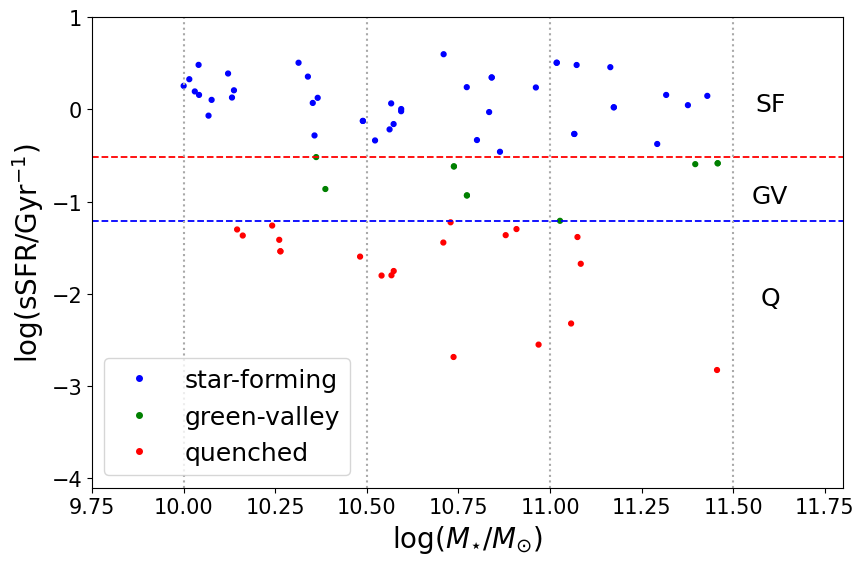

In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import caesar
import matplotlib.lines as mlines

#plt.rc('text', usetex=False)  # Disable LaTeX integration

if __name__ == '__main__':
    model = "m50n512"
    wind = "s50"
    snap = "078"

    data_dir = f'/home/rad/data/{model}/{wind}/'
    sim = caesar.load(f'{data_dir}Groups/{model}_{snap}.hdf5')
    redshift = sim.simulation.redshift

    t_hubble_Gyr = 3.278
    quench = np.log10(1 / t_hubble_Gyr)
    star_forming_cut = np.log10(0.2 / t_hubble_Gyr)

    sample_dir = f'/home/pedroleo/pedroshp/samples/'
    sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'
    with h5py.File(sample_file, 'r') as sf:
        gal_sm = sf['mass'][:]
        gal_ssfr = sf['ssfr'][:]+9
        gal_ids = sf['gal_ids'][:]

    colors = []
    SF_ids = [128,257,130,261,265,137,10,13,15,18,148,26,28,38,295,39,303,49,50,183,185,186,57,189,318,319,322,198,71,74,75,332,80,340,84,96,118,119,125]
    GV_ids = [8,12,47,177,83,184,90]
    Q_ids = [133,9,154,36,37,41,45,56,62,66,210,211,217,91,93,97,246,124,253,126]
    
    for gid in gal_ids:
        if gid in SF_ids:
            colors.append('blue')
        elif gid in GV_ids:
            colors.append('green')
        elif gid in Q_ids:
            colors.append('red')
        else:
            colors.append('white')  # default color for other galaxies

    plt.scatter(gal_sm, gal_ssfr, c=colors, s=12, marker='o', label='SIMBA sample')
    plt.axhline(quench, ls='--', lw=1.3, c='red')
    plt.axhline(star_forming_cut, ls='--', lw=1.3, c='blue')
    plt.text(11.56, quench+0.5, 'SF')
    plt.text(11.55, quench-0.5, 'GV')
    plt.text(11.575, quench-1.6, 'Q')



    delta_m = 0.5 #Pedro changed from 0.25
    min_m = 10.
    nbins_m = 3 #Pedro changed from 6
    for i in range(nbins_m + 1):
        plt.axvline(min_m+i*delta_m, ls=':', lw=1.5, c='darkgray')



    # Create proxy artists for the legend with filled circles
    star_forming_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                                        markersize=4, label='star-forming')
    green_valley_marker = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                                        markersize=4, label='green-valley')
    quenched_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                                    markersize=4, label='quenched')


    plt.legend(handles=[star_forming_marker, green_valley_marker, quenched_marker])
      

    plt.xlim(9.75, 11.8)
    plt.ylim(-4.1, 1.0)
    #plt.xlabel(r'log (Mstar / M_sun)')
    #plt.ylabel(r'log (sSFR / Gyr^-1)')

    plt.rc('text', usetex=True)
    plt.xlabel(r'$\log (M_{\star} / M_{\odot})$')
    plt.ylabel(r'$\log (\mathrm{sSFR} / \mathrm{Gyr}^{-1})$')


    #plt.legend(loc=3)
    plt.tight_layout()
    plt.savefig(f'/home/pedroleo/pedroshp/fully_mine_code/gal_sample_jet.png', dpi=300)
    plt.show()


In [3]:
SF_ids = [128,257,130,261,265,137,10,13,15,18,148,26,28,38,295,39,303,49,50,183,185,186,57,189,318,319,322,198,71,74,75,332,80,340,84,96,118,119,125]
GV_ids = [8,12,47,177,83,184,90]
Q_ids = [133,9,154,36,37,41,45,56,62,66,210,211,217,91,93,97,246,124,253,126]

print(len(SF_ids), len(GV_ids), len(Q_ids))

39 7 20


In [5]:
import h5py
import numpy as np

sample_dir = '/home/pedroleo/pedroshp/samples/'
model = "m50n512"
wind = "s50"
snap = "078"
sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'

# load data
with h5py.File(sample_file, 'r') as sf:
    all_gal_sm = sf['mass'][:]  # All galaxy masses
    all_gal_ids = sf['gal_ids'][:]  # All galaxy IDs

# specific galaxy IDs I want to include
specific_gal_ids = [8, 10, 9, 265, 50, 49, 12, 13, 18, 26, 62, 71, 90, 93, 15, 119, 37, 184, 36, 28, 125, 47, 38, 84, 130, 39, 80, 97, 57, 74, 41, 56, 322, 75, 96, 177, 45, 83, 246, 126, 91, 66, 137, 211, 198, 340, 118, 303, 148, 210, 128, 183, 332, 124, 217, 154, 189, 133, 185, 186, 295, 253, 257, 319, 261, 318]

# Filter the galaxy masses based on specific IDs
gal_sm = [all_gal_sm[np.where(all_gal_ids == id)[0][0]] for id in specific_gal_ids if id in all_gal_ids]

sf_masses = [m for id, m in zip(specific_gal_ids, gal_sm) if id in SF_ids]
gv_masses = [m for id, m in zip(specific_gal_ids, gal_sm) if id in GV_ids]
q_masses = [m for id, m in zip(specific_gal_ids, gal_sm) if id in Q_ids]

# Define mass bins from 10^10 to 10^12 Msun
bins = np.linspace(10, 11.5, num=4)  # num = 4 is 3 equally spaced bins

# Count the number of galaxies in each bin
sf_counts, _ = np.histogram(sf_masses, bins=bins)
gv_counts, _ = np.histogram(gv_masses, bins=bins)
q_counts, _ = np.histogram(q_masses, bins=bins)

print("Star-Forming Galaxy Counts:", sf_counts)
print("Green Valley Galaxy Counts:", gv_counts)
print("Quenched Galaxy Counts:", q_counts)


Star-Forming Galaxy Counts: [16 13 10]
Green Valley Galaxy Counts: [2 2 3]
Quenched Galaxy Counts: [6 9 5]


In [73]:
SF_ids = [128,257,130,261,265,137,10,13,15,18,148,26,28,38,295,39,303,49,50,183,185,186,57,189,318,319,322,198,71,74,75,332,80,340,84,96,118,119,125]
GV_ids = [8,12,47,177,83,184,90]
Q_ids = [133,9,154,36,37,41,45,56,62,66,210,211,217,91,93,97,246,124,253,126]

base_gals = [8, 10, 9, 265, 50, 49, 12, 13, 18, 26, 62, 71, 90, 93, 15, 119, 37, 184, 36, 28, 125, 47, 38, 84, 130, 39, 80, 97, 57, 74, 41, 56, 322, 75, 96, 177, 45, 83, 246, 126, 91, 66, 137, 211, 198, 340, 118, 303, 148, 210, 128, 183, 332, 124, 217, 154, 189, 133, 185, 186, 295, 253, 257, 319, 261, 318]
match_gals = [5, 15, 4, 174, 90, 46, 9, 13, 28, 18, 47, 64, 76, 49, 63, 96, 22, 125, 21, 43, 134, 39, 92, 112, 78, 54, 79, 171, 81, 105, 27, 121, 351, 65, 165, 94, 31, 131, 133, 118, 62, 95, 83, 124, 267, 333, 84, 272, 126, 136, 73, 249, 540, 82, 142, 89, 187, 117, 166, 195, 312, 184, 404, 322, 251, 271]

# Create a dictionary to map each base galaxy ID to its match galaxy ID
galaxy_mapping = dict(zip(base_gals, match_gals))


In [94]:
# Mass statistics in each bin:

sample_dir = '/home/pedroleo/pedroshp/samples/'
model = "m50n512"
wind = "s50"
snap = "078"
sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'

# load data
with h5py.File(sample_file, 'r') as sf:
    all_gal_sm = sf['mass'][:]  # All galaxy masses
    all_gal_ids = sf['gal_ids'][:]  # All galaxy IDs

# specific galaxy IDs I want to include
specific_gal_ids = base_gals

# Filter the galaxy masses based on specific IDs
gal_sm = [all_gal_sm[np.where(all_gal_ids == id)[0][0]] for id in specific_gal_ids if id in all_gal_ids]

gal_sm = np.array(gal_sm)

#sf_masses = [m for id, m in zip(specific_gal_ids, gal_sm) if id in SF_ids]
#gv_masses = [m for id, m in zip(specific_gal_ids, gal_sm) if id in GV_ids]
#q_masses = [m for id, m in zip(specific_gal_ids, gal_sm) if id in Q_ids]

gal_ids = base_gals

"""
# Filter indices for galaxies in the specified mass bin
mass_bin_indices = np.where((gal_sm >= 10) & (gal_sm < 10.5))[0]

# Filter for quenched galaxies in the specified mass bin using gal_ids and mapping from galaxy_mapping if present
quenched_mass_bin_indices = [idx for idx in mass_bin_indices if gal_ids[idx] in Q_ids]
quenched_base_ids = [gal_ids[idx] for idx in quenched_mass_bin_indices]
quenched_mapped_ids = [galaxy_mapping.get(id) for id in quenched_base_ids if id in galaxy_mapping]

# Print the lists of base IDs and mapped IDs
print("Quenched in 10 to 10.5 bin: Base IDs:", quenched_base_ids)
print("Quenched in 10 to 10.5 bin: Mapped IDs:", quenched_mapped_ids)"
"""

# Define the mass bin
mass_bin_lower = 11
mass_bin_upper = 11.5

# Filter indices for galaxies in the specified mass bin
mass_bin_indices = np.where((gal_sm >= mass_bin_lower) & (gal_sm < mass_bin_upper))[0]

# Extract the galaxy IDs from the filtered indices
galaxies_in_bin_ids = [gal_ids[idx] for idx in mass_bin_indices]

# Print all galaxy IDs in the mass bin
print("Galaxy IDs in the defined mass bins:", galaxies_in_bin_ids)
#print(len(galaxies_in_bin_ids))

# Print the mapped IDs for all galaxy IDs in the mass bin

mapped_galaxies_in_bin_ids  = [galaxy_mapping.get(id) for id in galaxies_in_bin_ids if id in galaxy_mapping]
print("Mapped IDs for galaxies in the defined mass bins:", mapped_galaxies_in_bin_ids )

print("length test: ", len(mapped_galaxies_in_bin_ids))



#Now load no-jet data

import numpy as np
import h5py

# Directory and file setup for no-jet data
sample_dir = '/home/pedroleo/pedroshp/samples-nojet/'
model = "m50n512"
wind = "s50nojet"
snap = "078"
sample_file = f'{sample_dir}{model}_{wind}_{snap}_galaxy_sample.h5'

# Load the no-jet data
with h5py.File(sample_file, 'r') as sf:
    all_gal_sm = sf['mass'][:]  # All galaxy masses
    all_gal_ids = sf['gal_ids'][:]  # All galaxy IDs

# IDs to filter (mapped from the jet data set, now in the no-jet dataset)
specific_gal_ids = mapped_galaxies_in_bin_ids

# Filter the galaxy masses based on these specific mapped IDs
gal_sm_mapped_for_bins = [all_gal_sm[np.where(all_gal_ids == id)[0][0]] for id in specific_gal_ids if id in all_gal_ids]

# Convert to a numpy array for easier processing
gal_sm_mapped_for_bins = np.array(gal_sm_mapped_for_bins)

# Define mass bins and labels
mass_bins = [9.5,10, 10.5, 11, 11.5,12]  # Mass bins
mass_bin_labels = ['9.5-10','10-10.5', '10.5-11', '11-11.5',"11.5-12"]  # Labels for bins

# Determine which mass bin each galaxy belongs to
bin_indices = np.digitize(gal_sm_mapped_for_bins, mass_bins) - 1  # Get bin index for each mass

# Initialize a dictionary to count galaxies in each bin
bin_counts = {label: 0 for label in mass_bin_labels}

# Tally the counts for each bin using the bin indices
for idx in bin_indices:
    if 0 <= idx < len(mass_bin_labels):
        bin_counts[mass_bin_labels[idx]] += 1

# Print the count of galaxies in each bin
print("-----")
print("NOW NO JET: Galaxy counts in each mass bin for mapped IDs:")
for bin_label, count in bin_counts.items():
    print(f"{bin_label}: {count}")



Galaxy IDs in the defined mass bins: [8, 10, 9, 50, 49, 12, 13, 18, 26, 15, 37, 36, 28, 47, 38, 39, 41, 45]
Mapped IDs for galaxies in the defined mass bins: [5, 15, 4, 90, 46, 9, 13, 28, 18, 63, 22, 21, 43, 39, 92, 54, 27, 31]
length test:  18
-----
NOW NO JET: Galaxy counts in each mass bin for mapped IDs:
9.5-10: 0
10-10.5: 0
10.5-11: 2
11-11.5: 11
11.5-12: 5


In [1]:
# Percentage of galaxies that move up mass bin when no-jet.
#10 - 10-5
print(10/24 *100)
#10.5 - 11
print(9/24 *100)
#11-11.5
print(5/18 *100)

41.66666666666667
37.5
27.77777777777778
